# Mixed-Integer Linear Programming

Importing gurobi MIP solver and other required libraries

In [6]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import os
import csv

from utils.utils import load_data, plot_device, write_sol, write_stat_line

## Variant 1 - no rotation

In [34]:
models = {
    "model_with_bounds": bounds,
    "strong_bound": strong_bounds,
    "test": strong_bounds
}

In [16]:
def bounds(w, n, widths, heights, verbose=0):
    # Create a new model
    m = gp.Model('vlsi_v1')

    # Calculatin bounds
    chip_height_lb = min(heights)
    height_lb = (np.array(widths)@np.array(heights)) / w
    height_ub = sum(heights)
    x_ub = w - min(widths)
    y_ub = height_ub - min(heights)

    # Create variables
    coordinates_x = [m.addVar(vtype='I', name=f'x_{i}', ub=x_ub) for i in range(n)]
    coordinates_y = [m.addVar(vtype='I', name=f'y_{i}', ub=y_ub) for i in range(n)]
    max_heights = [m.addVar(vtype='I', name=f'max_y_{i}', lb=chip_height_lb, ub=height_ub) for i in range(n)]
    max_height = m.addVar(vtype='I', name='max_height', lb=height_lb, ub=height_ub)

    # Add constraints
    # Maximum heights
    m.addConstrs((max_heights[i] == coordinates_y[i] + heights[i] for i in range(n)))
    # Maximum height
    m.addConstr(max_height == gp.max_(max_heights))

    # Total width constraint
    for i in range(n):
        m.addConstr(coordinates_x[i] + widths[i] <= w)

    # No overlap constraints
    for i in range(n):
        for j in range(i + 1, n):
            j_is_left = m.addVar(vtype='B', name=f'j_is_left_{i}_{j}')
            m.addGenConstrIndicator(j_is_left, True, coordinates_x[i] >= coordinates_x[j] + widths[j])

            j_is_right = m.addVar(vtype='B', name=f'j_is_right_{i}_{j}')
            m.addGenConstrIndicator(j_is_right, True, coordinates_x[i] + widths[i] <= coordinates_x[j])

            j_is_down = m.addVar(vtype='B', name=f'j_is_down_{i}_{j}')
            m.addGenConstrIndicator(j_is_down, True, coordinates_y[i] >= coordinates_y[j] + heights[j])

            j_is_up = m.addVar(vtype='B', name=f'j_is_up_{i}_{j}')
            m.addGenConstrIndicator(j_is_up, True, coordinates_y[i] + heights[i] <= coordinates_y[j])

            m.addConstr(j_is_left + j_is_right + j_is_down + j_is_up >= 1)

    # Set objective function
    m.setObjective(max_height, gp.GRB.MINIMIZE)

    # Solve it!
    m.Params.output_flag = verbose
    m.Params.time_limit = 300.0
    m.optimize()

    return m.getAttr('runtime'), [v.X for v in coordinates_x], [v.X for v in coordinates_y], max_height.X


In [31]:
def strong_bounds(w, n, widths, heights, verbose=0):
    # Create a new model
    m = gp.Model('vlsi_v1')

    # Calculating bounds
    height_lb = (np.array(widths)@np.array(heights)) / w
    height_ub = sum(heights)

    # Create variables
    coordinates_x = [m.addVar(vtype='I', name=f'x_{i}', ub=w - widths[i]) for i in range(n)]
    coordinates_y = [m.addVar(vtype='I', name=f'y_{i}', ub=height_ub - heights[i]) for i in range(n)]
    chip_heights = [m.addVar(vtype='I', name=f'max_y_{i}', lb=heights[i], ub=height_ub) for i in range(n)]
    max_height = m.addVar(vtype='I', name='max_height', lb=height_lb, ub=height_ub)

    # Add constraints
    # Maximum heights
    m.addConstrs((chip_heights[i] == coordinates_y[i] + heights[i] for i in range(n)))
    # Maximum height
    m.addConstr(max_height == gp.max_(chip_heights))

    # No overlap constraints
    for i in range(n):
        for j in range(i + 1, n):
            j_is_left = m.addVar(vtype='B', name=f'j_is_left_{i}_{j}')
            m.addGenConstrIndicator(j_is_left, True, coordinates_x[i] >= coordinates_x[j] + widths[j])

            j_is_right = m.addVar(vtype='B', name=f'j_is_right_{i}_{j}')
            m.addGenConstrIndicator(j_is_right, True, coordinates_x[i] + widths[i] <= coordinates_x[j])

            j_is_down = m.addVar(vtype='B', name=f'j_is_down_{i}_{j}')
            m.addGenConstrIndicator(j_is_down, True, coordinates_y[i] >= coordinates_y[j] + heights[j])

            j_is_up = m.addVar(vtype='B', name=f'j_is_up_{i}_{j}')
            m.addGenConstrIndicator(j_is_up, True, coordinates_y[i] + heights[i] <= coordinates_y[j])

            m.addConstr(j_is_left + j_is_right + j_is_down + j_is_up >= 1)

    # Set objective function
    m.setObjective(max_height, gp.GRB.MINIMIZE)

    # Solve it!
    m.Params.output_flag = verbose
    m.Params.time_limit = 300.0
    m.optimize()

    return m.getAttr('runtime'), [v.X for v in coordinates_x], [v.X for v in coordinates_y], max_height.X


In [32]:
def execute(instance, exec_name, save_sol=True, display_image=True, save_image=True, verbose=0):
    path = os.path.abspath('')

    w, n, widths, heights = load_data(instance)

    runtime, c_x, c_y, h = models[exec_name](w, n, widths, heights, verbose=verbose)

    if save_sol:
        write_sol(path + f'/out/{exec_name}/{instance}.txt', w, h, n, widths, heights, c_x, c_y)

    if display_image:
        plot_device(c_x, c_y, widths, heights, max(w, h), max(w, h))

    if save_image:
        plot_device(c_x, c_y, widths, heights, max(w, h), max(w, h), path + f'/img/{exec_name}/{instance}.png')

    return runtime, h


In [22]:
exec_name = 'model_with_bounds'
for i in range(1, 12):
    t, h = execute(i, exec_name, display_image=False)
    write_stat_line(os.path.abspath('') + f'/stats/{exec_name}.csv', i, h, t)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

(26, 22, [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 3, 4, 5, 7, 8, 11, 14])
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 253 rows, 991 columns and 968 nonzeros
Model fingerprint: 0x3de39f43
Model has 925 general constraints
Variable types: 0 continuous, 991 integer (924 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [3e+00, 2e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 947 rows and 22 columns
Presolve time: 0.02s
Presolved: 1200 rows, 1013 columns, 3828 nonzeros
Variable types: 0 continuous, 1013 integer (946 binary)
Found heuristic solution: objective 166.0000000
Found heuristic solution: objective 165.0000000
Found h

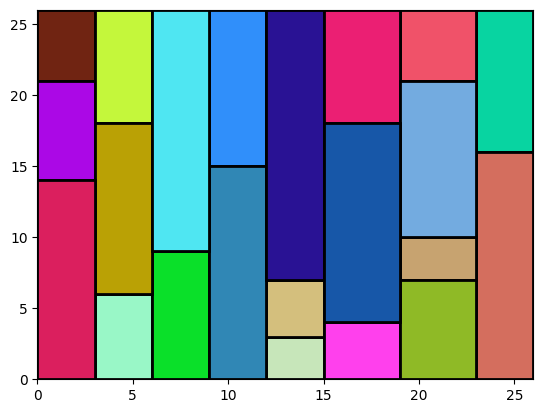

Execution time: 31.775794982910156
Height of the silicon plate: 26.0


In [36]:
print(load_data(19))
r, h = execute(19, "test", save_sol=False, save_image=False, verbose=1)

print(f'Execution time: {r}\nHeight of the silicon plate: {h}')

In [ ]:
0 1 2 3 4 5 6 7 8 9 19 11 12 13 14 15
